# Init

## Utils

In [1]:
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn import svm
from sklearn.model_selection import cross_validate
import os
from glob import glob


# Data

## Load Data

In [2]:
def get_summary(table, field):
    print("nan ratio:", table[field].isnull().sum()/table.shape[0])
    print("nan rows: ", table[field].isnull().sum())
    print(table[field].fillna("nan").value_counts())
    
def email_cleanup(table, key="emailaddress1"):
    if key not in table.columns:
        raise "key is not in table.columns"
    table = table.dropna(subset=[key]) # remove nan
    table.loc[:, key] = table[key].str.replace("'", "").str.lower() # lower case, clean single quote
    table = table[(~table[key].str.contains("rockwell|pisrc|bounteous|test"))] # remove rockwell related email
    return table

### AEM.raw 
- stage 1 should not drop duplicate because the eventlist probably exist only on some of pdf view records

#### (bingeID Only)

In [3]:
# _dt = pd.read_csv("all_binge_data_TOP1000000_2022-10-16.csv", nrows=1000000, index_col=0)
# aem_raw = pd.read_csv("aemRaw_2022-04-21-all_fields.csv", index_col=0)

#### load all
- reason => some rows without Elq contactID will still visit asset -> so, using mcvisid to track user_journey
    - but still, the total tracking email number will not change => 35

In [59]:
# files = sorted([file for file in glob("./aem_raw/*.csv") if "aemRaw_keyColumns_2022" in file])[-4::]
# print(files)

# df = pd.DataFrame()
# for file in files:
#     current = pd.read_csv(file)
#     df = pd.concat([df, current])

['./aem_raw/aemRaw_keyColumns_20221001-20221015.csv', './aem_raw/aemRaw_keyColumns_20221015-20221031.csv', './aem_raw/aemRaw_keyColumns_20221101-20221115.csv', './aem_raw/aemRaw_keyColumns_20221115-20221130.csv']


#### prefiltering with mcvisid

In [4]:
email_mcvisid = pd.read_csv("email_mcvisid.csv")

In [ ]:
files = sorted([file for file in glob("./aem_raw/*.csv") if "aemRaw_keyColumns_2022" in file])
stored_files = sorted([file for file in glob("./target_mcvisid/*.csv") if "aemRaw_keyColumns_2022" in file])

output_folder = "target_mcvisid"

for file in files:
    output_filename = file.replace("aem_raw", output_folder)
    if output_filename in stored_files:
        print(f"already processed this file {output_filename} in the target_mcvisid folder")
        continue
    current = pd.read_csv(file, nrows=None)
    keep_data = current.merge(email_mcvisid, how="inner", on="mcvisid")
    keep_data.to_csv(output_filename, index=None)
    print(output_filename, " --> with rows: ", keep_data.shape[0])

already processed this file in the target_mcvisid folder
already processed this file in the target_mcvisid folder
already processed this file in the target_mcvisid folder
already processed this file in the target_mcvisid folder
already processed this file in the target_mcvisid folder
already processed this file in the target_mcvisid folder
already processed this file in the target_mcvisid folder


/Users/wy/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (22,24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


./target_mcvisid/aemRaw_keyColumns_20220715-20220731.csv  --> with rows:  1272473
./target_mcvisid/aemRaw_keyColumns_20220801-20220815.csv  --> with rows:  1550335


#### load partial from local

In [ ]:
df = pd.DataFrame()
for file in stored_files:
    current = pd.read_csv(file)
    df = pd.concat([df, current])
    print("current rows: ", df.shape[0])

In [6]:
aem_raw = df

#### parsing

In [7]:
stage1_raw = aem_raw.dropna(subset=["BingeScoredAssetPath"]).reset_index(drop=True)
# stage1_raw = stage1_raw.drop_duplicates(subset=["DateTime_UTC", "EloquaContactId", "SessionVisitorId", "BingeScoredAssetPath"], keep='last') 

stage2_raw = aem_raw.dropna(subset=["BingeScoredAssetPath"]).reset_index(drop=True)
# stage2_raw = stage2_raw.drop_duplicates(subset=["DateTime_UTC", "SessionVisitorId", "BingeScoredAssetPath"], keep='last')

print("stage1_raw: unique SessionVisitorId: ", stage1_raw["SessionVisitorId"].unique().shape)
print("stage2_raw: unique mcvisid: ", stage2_raw["mcvisid"].unique().shape)

stage1_raw: unique SessionVisitorId:  (1319,)
stage2_raw: unique mcvisid:  (1319,)


### crm Lead
- unique EloquaContactId -> do some update on this table for the same ID

In [8]:
_lead = pd.read_csv("crm_Lead_20221116_all.csv", index_col=0)
crm_lead = email_cleanup(_lead, "emailaddress1")

/Users/wy/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (8,9,13,15,17,31,43,44,45,46,49,50,51,56,58,59,63,64,68,70,72,74,76,78,81,83,84,85,89,92,94,97,99,109,112,113,114,115,117,124,135,136,137,138,140,142,143,144,145,157,159,164,165,166,167,178,182,185,188,198,200,204,207,208,216,217,219,223,224,229,230,232,238,240,246,247,252,253,256,257,258,261,262,266,267,268,272,274,275,284,286,287,289,293,294,307,311,313) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/wy/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilo

### elo.contact
- from gated content form?
- unique EloquaContactId -> do some update on this table for the same ID

In [9]:
# _elq = pd.read_csv("all_elo_data_TOP1000000_2022-10-16.csv", nrows=1000000, index_col=0)
_elq = pd.read_csv("elq_all_bridge-only.csv", index_col=0)
elq = email_cleanup(_elq, "EmailAddress")
elq_bridge = elq[["EmailAddress", "EloquaContactId"]]


/Users/wy/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [10]:
elq_bridge.groupby("EmailAddress").size().sort_values()

EmailAddress
!!edson.carlos!!@ensinger.co.uk         1
marilyn.getz@electroswitch.com          1
marilyn.gerard@dawnfoods.com            1
marilyn.garaguso@alliedbeverage.com     1
marilyn.gagnon@airbus.com               1
                                       ..
c_rudiyono@yahoo.com                   15
dixie_bvn@hotmail.com                  17
123@yahoo.com                          18
eric.dacer@ptcerna.com                 20
nancy.cordoba@elvatron.com             21
Length: 6251714, dtype: int64

# Ideas
- business targets
    1. attractness: provide more interesting content for users
        - ranking content + recommendation based
    2. engagement: reach out and prioritize on target users
        - identify potential lead, find patterns and build segmentations between users based on their upload informaton
            - website visiting records -> AEM.raw? <font color=red>need specialized and ingested related data...</font>
            - interactions with sales people -> CRM.Lead? <font color=red>need clean, maintain and more explaination on the existing data... </font>
            - their demographic information -> CRM.Lead / Elq.Contact (this is quite clean)
    3. conversion: sales people effort?
    4. retain: ...

- questions
    - `Next steps: use data that is going into content scoring to predict user propensity`
    - how this weight score can help next step for potential lead prediction?
        - treat it as an feature to another model? the distance between sample is more important. It should be separatable.
        - two-stage model? or just change labels
        
- reference:
    - e.g. in recommendation system
    - <img src="https://assets.zilliz.com/2_29e27eb9b1.png" width="400"/>
    - <img src="https://cdn-images-1.medium.com/max/800/0*U5iR5NTSChuSOcyc." width="400"/>

### funnel

<div>
    <img src="https://www.wordstream.com/wp-content/uploads/2022/08/content-marketing-funnel-full-size.png" width="500"/>
</div>
    

# Feature Engineering


## Preprocessing - TF-IDF (NLP)

- TF-IDF = Term Frequency (TF) * Inverse Document Frequency (IDF)
    - idf(t) = log(N/(df + 1))
        <img src="https://cdn-media-1.freecodecamp.org/images/1*q3qYevXqQOjJf6Pwdlx8Mw.png" width="500"/>
        <img src="https://preview.redd.it/clwuxvtqpeq91.png?width=397&format=png&auto=webp&s=ae6788cefae9b83b3033db3612ec83e8f5ded24f" width="500"/>
    - rather directly using count frequency in the naive bayesian, using TF-IDF to adjust the features
    
- preprocessing.StandardScaler()
    - should not use because the features importance are dependent on the frequency, which is already kind of information

## stage1: wrapping data
- label: Submitted gated form (target)
    - generated by EventList
- features:
    - choosed:
        - BingeScoredAssetPath: Current BingeScoredAssetPath interaction on one session ( content sequence )
        - DateTime_UTC -> for concat sequence in visited order
    - possible:
        - BingeScoredAssetScore = manually set -> importance level for sales people
        - BingeCriticalScore = manually threshold -> initial threshold for sales people
        - PageURL? what information this URL can bring into model?
        
- original asset score manual setup ideas:
    - asset weight average is 1, if it is more important/meaningful -> bump up to 2;
    - if there are 5 assets in total, then default basic threshold is 5

## stage2: wrapping data
- label: is qualified lead or not (target)
    - stored on CRM Lead table, marked by sales people
- features: all the activities during the journey -> including asset browsing history 
    - choosed:
        - BingeScoredAssetPath: Current BingeScoredAssetPath interaction on one session ( content sequence )
        - DateTime_UTC -> for concat sequence in visited order
    - possible:
        - User information <font color=red>(this part are useful)</font>
            - industry
            - company size 
            - ...

In [11]:
def identify_pos(user_journey, label_type = 2):
    if label_type == 1:
        pos_code_statuscode = [953810011.0, 3.0, 953810008.0]
        isPos = user_journey["statuscode"].isin(pos_code_statuscode).any()
    elif label_type == 2:
        pos_code_ra_leadstage = [6.0, 7.0, 8.0]
        isPos = user_journey["ra_leadstage"].isin(pos_code_ra_leadstage).any()
    return isPos

def preprocessing_stage(user_journey, stage=1, target_method=0, feature_method="sequential", sep="$"):
    if stage == 1:
        if target_method == 0:
            target_event = [125, 126]
            events = ",".join(user_journey["EventList"].drop_duplicates().tolist())
            y = any([True for e in target_event if "," + str(e) in events]) * 1
        elif target_method == 1:
            y = (~user_journey["EloquaContactId"].isnull()).any()
        else:
            raise "no such target_method"
            
    elif stage == 2:
        y = any(user_journey["label"]) * 1
    
    if feature_method == "bow":
        page_view = user_journey.groupby("BingeScoredAssetPath")["BingeScoredAssetPath"].size().to_dict() # dict vectorizer
    elif feature_method == "sequential":
        page_view = sep.join(user_journey.sort_values(by="DateTime_UTC")["BingeScoredAssetPath"].tolist())
    else:
        raise "no such feature_method"
    
    # init_scores = user_journey.groupby(["BingeScoredAssetPath"])[["BingeCriticalScore","BingeScoredAssetScore"]].mean() # not sure how to append as weighted matrix
#     asset_user_journey_seq = user_journey.sort_values(by="DateTime_UTC")["BingeScoredAssetPath"].tolist()
    return pd.Series([page_view, y], index=["features", "label"])

def evaluate_metrics(y_test, y_pred, show_plots=False):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    auc_score = auc(fpr, tpr)
    pre, rec, thresholds = precision_recall_curve(y_test, y_pred, pos_label=1)
    prc_score = auc(rec, pre)

    if show_plots:
        print(classification_report(y_test, y_pred>0.5))
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('AUC')

        plt.subplot(1, 2, 2)
        plt.plot(rec, pre, color='darkorange', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('PRC')
        plt.tight_layout()

        plt.show()

    print("AUC: {:.2%}, PRC: {:.2%}".format(auc_score, prc_score))
    
SEP_TOKEN_PATTERN = "[^\$]+"
SEED = 42
TEST_SIZE = 0.2

# Modeling



## Stage-1: Scoring content - visitor preference 
- rethink:
    - what is the most attractive content for visitor v.s. what is the most attractive content for salespeople?
        - SubmitGatedForm action is not marked by sales people, it's kind of inclination level from user side
        - the model is trying to know which asset is more important for SubmitGatedForm 
        - how important for user to submit GCDC

    - weight should be from sales people definition, but current method can only get the attractive score on visitor aspect => 
        - assumption-1: more clicks => interesting to connect? <font color=red>submit GCDC == made a reach out decision? YES?</font>
        - they will think the information are valuable for them, want to get more related information -> salespeople reach out? When is the time = threshold?

In [12]:
data = stage1_raw.groupby("SessionVisitorId").apply(lambda x: preprocessing_stage(x))

### Data split + TFIDF
<!-- 
# ## outdated
# data = stage1_raw.groupby("SessionVisitorId").apply(lambda x: processing_stage1(x, target_method=1, feature_method="bow"))
# data["submitted_form"].value_counts()

# def tfidf_transform(dtm, idf=None):
#     N = dtm.shape[0] # number of document
#     tf = (dtm/(dtm.sum(axis=1).reshape(-1,1)))

#     if idf is None:
#         idf = np.log(1 + N/(dtm.astype(bool).sum(axis=0)))
        
#     tfidf = tf * idf
#     return tfidf, idf
# v = DictVectorizer(sparse=False)
# X_train_dtm = v.fit_transform(X_train)
# X_test_dtm = v.transform(X_test)
# X_train_arr, idf = tfidf_transform(X_train_dtm)
# X_test_arr, _ = tfidf_transform(X_test_dtm, idf) -->

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data["features"], data["label"].values, test_size=TEST_SIZE, stratify=data["label"].values, random_state=SEED)

print("training sample label size:", Counter(y_train))
print("pos vs neg in training set:")
print(data["label"].value_counts())
print("testing sample label size:", Counter(y_test))

vectorizer = TfidfVectorizer(token_pattern=SEP_TOKEN_PATTERN)

X_train_arr = vectorizer.fit_transform(X_train)
X_test_arr = vectorizer.transform(X_test)

training sample label size: Counter({0: 689, 1: 366})
pos vs neg in training set:
0    862
1    457
Name: label, dtype: int64
testing sample label size: Counter({0: 173, 1: 91})


### Models

#### LR

In [14]:
model = LogisticRegression()
model.fit(X_train_arr, y_train)
# model.coef_

LogisticRegression()

#### svm (x)
- no weight but only predict prob 

              precision    recall  f1-score   support

           0       0.84      0.80      0.82       173
           1       0.65      0.71      0.68        91

    accuracy                           0.77       264
   macro avg       0.75      0.76      0.75       264
weighted avg       0.78      0.77      0.77       264



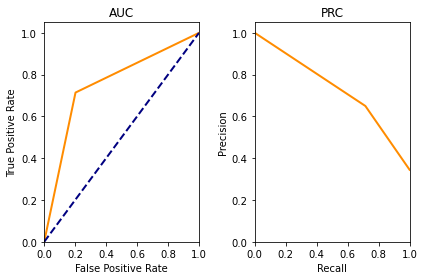

AUC: 75.60%, PRC: 73.14%


In [15]:
svm_clf = svm.SVC(kernel='linear', C=1)
svm_clf.fit(X_train_arr, y_train)
y_pred = svm_clf.predict(X_test_arr)
evaluate_metrics(y_test, y_pred, show_plots = True)

#### naive bayes
- $\theta_{yi}$ is the probability $P(x_i \mid y)$ of feature i appearing in a sample belonging to class y.

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       173
           1       0.67      0.71      0.69        91

    accuracy                           0.78       264
   macro avg       0.76      0.76      0.76       264
weighted avg       0.78      0.78      0.78       264



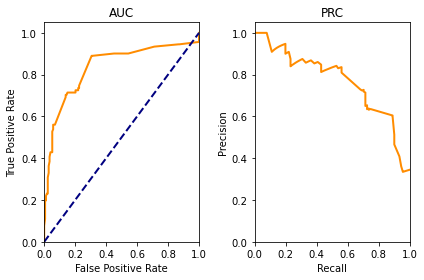

AUC: 83.67%, PRC: 76.95%


In [16]:
clf = MultinomialNB().fit(X_train_arr, y_train)
asset_prob = np.exp(clf.feature_log_prob_[0])
# clf.feature_log_prob_[0]
y_pred = (clf.predict_proba(X_test_arr))[:, 1]
evaluate_metrics(y_test, y_pred, show_plots = True)

### <font color=red>cross validation</font>
<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="500"/>

In [17]:
scores = cross_validate(clf, X_train_arr, y_train, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores["test_score"].mean(), scores["test_score"].std()))

0.79 accuracy with a standard deviation of 0.02


### Assign Weight (kind of user preference)
- conditional prob

In [18]:
# log p(w|c=1) + log p(w|c=0)
import numpy as np
asset_prob = np.exp(clf.feature_log_prob_[0])

In [19]:
weights = pd.DataFrame([vectorizer.get_feature_names(), asset_prob.tolist()]).T
weights.columns = ["asset", "weight"]
weights.sort_values(by="weight", ascending=False).style

,asset,weight
46,/content/rockwell-automation/www/na/us/en_us/company/news/case-studies/hirata-emulation-software.html,0.147548
47,/content/rockwell-automation/www/na/us/en_us/company/news/case-studies/maximum-transparency-across-all-levels-at-samsung-sdi-battery-sy.html,0.146164
2,/content/dam/rockwell-automation/sites/downloads/pdf/auto-ar001_-en-p.pdf,0.144098
3,/content/dam/rockwell-automation/sites/downloads/pdf/auto-sp010_-en-p.pdf,0.143090
48,/content/rockwell-automation/www/na/us/en_us/company/news/presentations/electric-vehicle-innovation-center.html,0.116599
6,/content/dam/rockwell-automation/sites/downloads/pdf/getting started in iab.pdf,0.070596
30,/content/dam/rockwell-automation/videos/events/af-2022/on-demand/new-and-next-at-rockwell-automation/new-and-next-at-rockwell-automation-en.mp4,0.058812
7,/content/dam/rockwell-automation/sites/downloads/pdf/project design assistant.pdf,0.034073
8,/content/dam/rockwell-automation/sites/downloads/pdf/using the architecture view.pdf,0.013090
4,/content/dam/rockwell-automation/sites/downloads/pdf/export a bom to proposalworks.pdf,0.010486


## Stage-2: Potential Lead - Sales people aspect
- with the label from sales people
    - type-1: interaction on Binge within lead status promote time range (30 days)
    - type-2: is existed qualified lead or not 
- conversion transition (which stage of conversion)
    - reading asset A has higher probably to become a existing lead compared with reading asset B
- assumption
    - <font color=red>only consider people already shows their interest in the funnel (only elq ID exist)</font>. So, this is kind of stage2 filter.
        - stage1 filter will consider anonomys visitors, and make them keep interest and leave information in elq first 
    - potential lead will have the similar interaction patterns as existing lead

### tables relationship
```SQL
FROM aem.RawTraffic AS binge 
    LEFT JOIN elo.Contact AS contact ON binge.EloquaContactId = contact.EloquaContactId
    LEFT JOIN crm.Lead AS lead ON lead.emailaddress1 = contact.EmailAddress
```
- relationship
    - elq is the bridge table 
        - elq ID : Email = <font color=red>N</font>:1 
        - overwrite
    - crm_lead
        - account id : Email = 1:N 
        - add new row
    - stage2_raw
        - session id : elq ID = 1:1
        - add new row
        - mvcid : elq ID = 1:N

#### email to mcvisid

In [20]:
email_to_mcvisid = elq_bridge[["EmailAddress", "EloquaContactId"]].merge(stage2_raw[["EloquaContactId", "mcvisid"]].drop_duplicates(), on="EloquaContactId")
email_to_mcvisid = email_to_mcvisid[["EmailAddress", "mcvisid"]].drop_duplicates()

In [21]:
stage2_raw

,SessionVisitorId,VisitPageNumber,VisitNumber,NewVisit,EventList,DateTime_UTC,PageURL,VisitReferrer,VisitReferrerType,VisitorDomain,...,mcvisid,GeoCity,GeoCountry,GeoRegion,PDFurl,PDFpagecount,BingeId,BingeCriticalScore,BingeScoredAssetPath,BingeScoredAssetScore
0,7421626168734539978_3431381547424998592,33,4,False,"215,216=65.00,10035,10036,10037,10038,10039,10...",2022-10-01 04:32:33+06:00,https://www.rockwellautomation.com/en-us/suppo...,NaN,6,103.85.162.66,...,90813010319485319523501709624937862303,rajshahi,bgd,e,/content/dam/rockwell-automation/sites/downloa...,15.0,be1650550449644850,5.0,/content/dam/rockwell-automation/sites/downloa...,1.0
1,7421626168734539978_3431381547424998592,34,4,False,"215,216=10.00,217=1.00,10035,10036,10037,10038...",2022-10-01 04:32:43+06:00,https://www.rockwellautomation.com/en-us/suppo...,NaN,6,103.85.162.66,...,90813010319485319523501709624937862303,rajshahi,bgd,e,/content/dam/rockwell-automation/sites/downloa...,15.0,be1650550449644850,5.0,/content/dam/rockwell-automation/sites/downloa...,1.0
2,7421626168734539978_3431381547424998592,35,4,False,"207,208=10.00,10020,10022,10023,10024,10025,10...",2022-10-01 04:32:43+06:00,https://www.rockwellautomation.com/en-us/suppo...,NaN,6,103.85.162.66,...,90813010319485319523501709624937862303,rajshahi,bgd,e,/content/dam/rockwell-automation/sites/downloa...,15.0,NaN,NaN,/content/dam/rockwell-automation/sites/downloa...,1.0
3,7421626168734539978_3431381547424998592,36,4,False,"206,182,183,185,186,187,188,190,192,10020,1002...",2022-10-01 04:32:51+06:00,https://www.rockwellautomation.com/en-us/suppo...,NaN,6,103.85.162.66,...,90813010319485319523501709624937862303,rajshahi,bgd,e,/content/dam/rockwell-automation/sites/downloa...,15.0,NaN,NaN,/content/dam/rockwell-automation/sites/downloa...,1.0
4,7421626168734539978_3431381547424998592,37,4,False,"273,175,176,177,113",2022-10-01 04:32:54+06:00,https://www.rockwellautomation.com/en-us/suppo...,NaN,6,103.85.162.66,...,90813010319485319523501709624937862303,rajshahi,bgd,e,/content/dam/rockwell-automation/sites/downloa...,15.0,NaN,NaN,/content/dam/rockwell-automation/sites/downloa...,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51160,5841280485151499745_5339177803023877420,41,20,False,"262,159,160,161,113",2022-11-30 00:11:47-05:00,https://www.rockwellautomation.com/en-us/compa...,NaN,6,spectrum.com,...,84130602613052026612644619895919273961,sturbridge,usa,ma,NaN,NaN,be1667335927367622,2.0,/content/dam/rockwell-automation/videos/produc...,2.0
51161,5841280485151499745_5339177803023877420,42,20,False,"215,216=185.00,10035,10036,10037,10038,10039,1...",2022-11-30 00:12:17-05:00,https://www.rockwellautomation.com/en-us/compa...,NaN,6,spectrum.com,...,84130602613052026612644619895919273961,sturbridge,usa,ma,NaN,NaN,be1667335927367622,2.0,/content/dam/rockwell-automation/videos/produc...,2.0
51162,5841280485151499745_5339177803023877420,43,20,False,"215,216=10.00,217=2.00,10035,10036,10037,10038...",2022-11-30 00:12:28-05:00,https://www.rockwellautomation.com/en-us/compa...,NaN,6,spectrum.com,...,84130602613052026612644619895919273961,sturbridge,usa,ma,NaN,NaN,be1667335927367622,2.0,/content/dam/rockwell-automation/videos/produc...,2.0
51163,5841280485151499745_5339177803023877420,44,20,False,"264,159,160,161,162,182,183,185,186,187,188,18...",2022-11-30 00:13:28-05:00,https://www.rockwellautomation.com/en-us/compa...,NaN,6,spectrum.com,...,84130602613052026612644619895919273961,sturbridge,usa,ma,NaN,NaN,NaN,NaN,/content/dam/rockwell-automation/videos/produc...,2.0


### positive signal
1. method A: within a month & the statuscodename change from unQualified to Qualified
    1. ra_leadstage increase 1
2. <font color=red>method B: identify all the existing lead, find the visitor has the similar pattern on binge asset</font>

In [22]:
# elq_bridge.groupby("EmailAddress").size().sort_values()

In [23]:
crm_qualify_label = crm_lead.groupby("emailaddress1").apply(lambda user_journey: identify_pos(user_journey, label_type = 2))
crm_qualify_label = crm_qualify_label.to_frame().reset_index()
crm_qualify_label.columns = ["emailaddress1", "label"]
crm_qualify_label.label.value_counts()

False    133201
True       1951
Name: label, dtype: int64

In [24]:
email_to_mcvisid

,EmailAddress,mcvisid
0,2646341@fedex.com,79956990968260977812960998803356334557
1,aaron.britt@tulip.co,15631237595222005634321735052967980870
2,abeilby@maplesoft.com,34529761632086388684448452867579883871
3,acordova@hermos.com.mx,18998225164086952284034325275436283906
4,adam.ferran.7s@etcwinders.com,09178376918996224770872301436727086686
...,...,...
236,vinicius.magalhaes@installautomacao.com.br,69820125967591818764294911251525450864
237,vokevin@amazon.com,50671350259141314951249291927759831366
238,yvonne@aauto.com.tw,43718471598741409674596236122126962883
239,z.jakas@biovast.lt,72594691410406412551647411969256670908


In [25]:
email_to_label = email_to_mcvisid.merge(crm_qualify_label, left_on=["EmailAddress"], right_on=["emailaddress1"], how='inner')
email_to_label = email_to_label[["EmailAddress","label", "mcvisid"]].drop_duplicates(subset=["mcvisid"]) 
# assert email_to_label.groupby("EmailAddress").size().sort_values()[-1] == 1 # EmailAddress 1: N mcvisid
print("keep rows:", email_to_label.shape)
# email_to_label.groupby("mcvisid").size() # should have samples that larger than 2

keep rows: (67, 3)


In [26]:
email_to_label

,EmailAddress,label,mcvisid
0,abeilby@maplesoft.com,False,34529761632086388684448452867579883871
1,adam.weber@grande.com,False,58910804186709493612462639601601442406
2,alberto.sanchez@vam-usa.com,True,43947329194604126840286312834344659697
3,albindesign@hotmail.com,False,39574178637007564670511457600716978527
4,albindesign@hotmail.com,False,43308186621157836851480940823198434745
...,...,...,...
62,sam_automation@nexonautomation.com,False,68104007505241838892868048281690945143
63,sarawut.focusautomation@gmail.com,False,71351318900366502264473341891206232603
64,skalnikovakatka@gmail.com,False,06928927345720822133313723390868635851
65,t.sullivan@tmtsolutions.com,False,47664162742309501391375632529673181081


In [27]:
_data = stage2_raw.merge(email_to_label, on="mcvisid")
data = _data.groupby("EmailAddress").apply(lambda x: preprocessing_stage(x, stage=2))

### Data split + TFIDF

In [28]:
X_train, X_test, y_train, y_test = train_test_split(data["features"], data["label"].values, test_size=TEST_SIZE, stratify=data["label"].values, random_state=SEED)
print("total:\n", data["label"].value_counts())
print("training sample label size:", Counter(y_train))
print("pos vs neg in training set:")
print("testing sample label size:", Counter(y_test))

vectorizer = TfidfVectorizer(token_pattern=SEP_TOKEN_PATTERN)

X_train_arr = vectorizer.fit_transform(X_train)
X_test_arr = vectorizer.transform(X_test)

total:
 0    59
1     4
Name: label, dtype: int64
training sample label size: Counter({0: 47, 1: 3})
pos vs neg in training set:
testing sample label size: Counter({0: 12, 1: 1})


### Models

In [29]:
clf = MultinomialNB().fit(X_train_arr, y_train)
y_pred = (clf.predict_proba(X_test_arr))[:, 1]
asset_prob = np.exp(clf.feature_log_prob_[0])

In [30]:
weights = pd.DataFrame([vectorizer.get_feature_names(), asset_prob.tolist()]).T
weights.columns = ["asset", "weight"]
weights.sort_values(by="weight", ascending=False).style

,asset,weight
20,/content/dam/rockwell-automation/videos/events/af-2022/on-demand/new-and-next-at-rockwell-automation/new-and-next-at-rockwell-automation-en.mp4,0.210748
17,/content/dam/rockwell-automation/videos/capabilities/process-solutions/plantpax-system-now-and-in-the-future/plantpax-system-now-and-in-the-future-en.mp4,0.100739
3,/content/dam/rockwell-automation/sites/downloads/pdf/getting started in iab.pdf,0.075873
7,/content/dam/rockwell-automation/videos/capabilities/cybersecurity/cybersecurity-watch-a-hack-in-real-time/cybersecurity-hack-in-real-time-en.mp4,0.044631
24,/content/dam/rockwell-automation/videos/products/software/factorytalk/factorytalk-design-studio-cloud-increase-design-efficiency/factorytalk-design-studio-cloud-increase-design-efficiency-en.mp4,0.040455
11,/content/dam/rockwell-automation/videos/capabilities/industrial-automation-and-control/micro-control-integrated-automation-solution/micro-control-integrated-automation-solution-en.mp4,0.040147
2,/content/dam/rockwell-automation/sites/downloads/pdf/export a bom to proposalworks.pdf,0.032982
18,/content/dam/rockwell-automation/videos/capabilities/process-solutions/process-control-what-is-new-and-next/process-control-new-and-next-en.mp4,0.029944
0,/content/dam/rockwell-automation/sites/downloads/pdf/applying pricing to bom.pdf,0.026706
6,/content/dam/rockwell-automation/videos/capabilities/cybersecurity/cip-security-improve-your-control-system-defense-in-depth-strategy/cip-security-improve-your-control-system-defense-in-depth-strategy-en.mp4,0.026535


              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       0.00      0.00      0.00         1

    accuracy                           0.92        13
   macro avg       0.46      0.50      0.48        13
weighted avg       0.85      0.92      0.89        13



/Users/wy/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wy/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wy/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


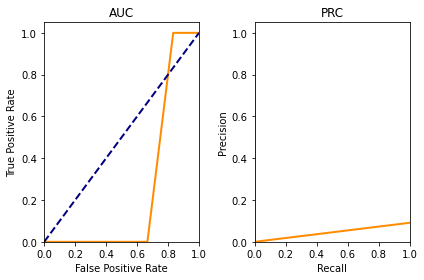

AUC: 25.00%, PRC: 4.55%


In [31]:
evaluate_metrics(y_test, y_pred, show_plots = True)

In [32]:
# weights["weight"]/weights["weight"].mean()

## Weight Rescaling
```python
default_critical_score = 1
if user click 0, 1, 2:
    then culmulative_score = 0.507937 + 0.349206 + 0.603175
        if culmulative_score > default_critical_score: 
            marked as potential qualify 
```

In [33]:
a = weights.iloc[0:5,:]

In [34]:
a["weight"]/a["weight"].sum() * 5

0    0.734047
1    0.636979
2    0.906548
3    2.085448
4    0.636979
Name: weight, dtype: object

In [35]:
a["weight"].mean()

0.03638214664957039

In [36]:
# elq_all_bridge-only.csv

In [37]:
(a["weight"]/a["weight"].sum())

0    0.146809
1    0.127396
2     0.18131
3     0.41709
4    0.127396
Name: weight, dtype: object

In [38]:
a["weight"]

0    0.026706
1    0.023175
2    0.032982
3    0.075873
4    0.023175
Name: weight, dtype: object

## Others 

### Sample Size estimation
Assumption
- Binomial Distribution

Testing
- Power = 1 - Type II Error
- Pr(True Positive) = 1 - Pr(False Negative)

<img src="https://sigmazone.com/wp-content/uploads/2018/06/Normal_Approx_Binomial_CI.gif" width="500"/>

In [39]:
from scipy.stats import norm

In [40]:
# estimate sample size via power analysis
# from statsmodels.stats.power import TTestIndPower

# # parameters for power analysis
# effect = 0.8
# alpha = 0.05
# power = 0.8
# # perform power analysis
# analysis = TTestIndPower()
# result = analysis.solve_power(effect, power=power, nobs1=None, ratio=1.0, alpha=alpha)
# print('Sample Size: %.3f' % result)

In [41]:
n = 63
pos = 4
p_hat = pos/n

#### CI with given N

In [42]:
alpha = .10

def get_CI(p_hat, n, alpha):
    ppf_list = norm.ppf(q=[alpha/2, 1-alpha/2], loc=0, scale=1)
    z_quantile = ppf_list[1]

    variance = p_hat * (1-p_hat)
    deviation = np.sqrt(p_hat * (1-p_hat)/n)
    CI_lower = p_hat - z_quantile * deviation
    CI_upper = p_hat + z_quantile * deviation
#     print("alpha level: ", alpha)
#     print("p_hat", p_hat)
    # print("z_quantile: ", z_quantile)
    # print("deviation: ", deviation)
#     print(f"CI: [{CI_lower}, {CI_upper}]")
    return [alpha, CI_lower, CI_upper, deviation, variance]

CI_list = []
for alpha in range(1, 11):
    CI_list.append(get_CI(p_hat, n, alpha/100))
CI_df = pd.DataFrame(CI_list, columns=["alpha", "CI_lower", "CI_upper", "deviation", "variance"])
CI_df

,alpha,CI_lower,CI_upper,deviation,variance
0,0.01,-0.015642,0.142626,0.030722,0.059461
1,0.02,-0.007977,0.134961,0.030722,0.059461
2,0.03,-0.003177,0.130161,0.030722,0.059461
3,0.04,0.000397,0.126587,0.030722,0.059461
4,0.05,0.003279,0.123705,0.030722,0.059461
5,0.06,0.005711,0.121273,0.030722,0.059461
6,0.07,0.007827,0.119157,0.030722,0.059461
7,0.08,0.009708,0.117276,0.030722,0.059461
8,0.09,0.011407,0.115578,0.030722,0.059461
9,0.10,0.012959,0.114025,0.030722,0.059461


#### required sample with given CI

In [43]:
# CI_length = 0.01
CI_length = p_hat * 0.5
print(f"With given CI_length: {CI_length}, required_numbers: {int(required_num)+1}")
required_num = 1 / (((CI_length/2)/z_quantile)**2 / (p_hat * (1-p_hat)))

NameError: name 'required_num' is not defined

### clustering based 
- how to estimated the probablity of some attributes
- how to assign weight based on this?

找到不同 status code 的数据分布是怎样的. 
- 确认方向之后, 对应的数据是否足够 是第一步. 
- 还是寻找数据

# Store model and prediction

# Post to AEM

In [ ]:
"04" in month_max_days.keys()

In [ ]:
crm_lead

In [ ]:
crm_lead[crm_lead["modifiedon"]>"2022-11-01"]["emailaddress1"].unique().shape

In [ ]:
crm_lead[crm_lead["modifiedon"]>"2022-04-01"]["emailaddress1"].unique().shape

In [ ]:
_lead[["emailaddress1"]]
crm_lead = email_cleanup(_lead, "emailaddress1")

In [ ]:
crm_lead[crm_lead["emailaddress1"] == "16309088jpr@gmail.com"]

In [ ]:
crm_lead

In [ ]:
aem_raw

In [ ]:
a = crm_lead[crm_lead["emailaddress1"].str.contains("123.com")]
a["emailaddress1"].sort_values()